In [2]:
# !pip install wurlitzer
# %load_ext wurlitzer

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from numba import cuda
import numba
import math
import time

# 1 - lire l'image :

> Indented block



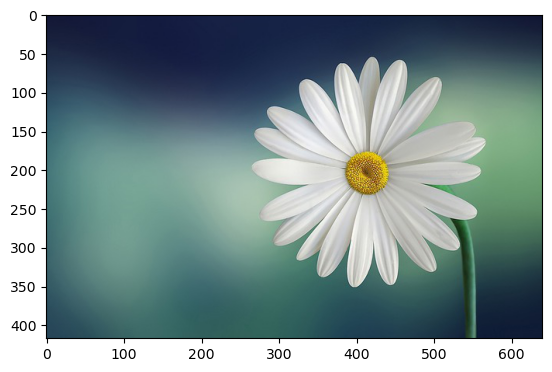

In [4]:
# Path to the image in your Google Drive
# image_path = "./ap1.jpg"
image_path = "./lpop.jpg"
# Open the image using Pillow
image = Image.open(image_path)

# Display the image
plt.imshow(image)


In [5]:
# Convert the Pillow image to a NumPy array
image_array = np.array(image)
image_array

array([[[18, 23, 53],
        [19, 24, 54],
        [19, 24, 54],
        ...,
        [16, 21, 51],
        [16, 21, 51],
        [16, 21, 51]],

       [[18, 23, 53],
        [19, 24, 54],
        [19, 24, 54],
        ...,
        [16, 21, 51],
        [16, 21, 51],
        [16, 21, 51]],

       [[19, 24, 54],
        [19, 24, 54],
        [19, 24, 54],
        ...,
        [16, 21, 50],
        [16, 21, 50],
        [16, 21, 50]],

       ...,

       [[39, 70, 88],
        [39, 70, 88],
        [39, 70, 88],
        ...,
        [16, 28, 54],
        [16, 28, 54],
        [16, 28, 54]],

       [[39, 70, 88],
        [39, 70, 88],
        [39, 70, 88],
        ...,
        [15, 27, 53],
        [15, 27, 53],
        [15, 27, 53]],

       [[38, 69, 87],
        [38, 69, 87],
        [39, 70, 88],
        ...,
        [16, 28, 54],
        [16, 28, 54],
        [16, 28, 54]]], dtype=uint8)

1 - MATRICE DE GAUSSIAN


In [13]:
kernel_size = 27
sigma = 11.4

gaussian = np.zeros((kernel_size, kernel_size))

@cuda.jit
def gk_blur(sigma, kernel_size, kernel):
    m = kernel_size // 2
    n = kernel_size // 2

    x, y = cuda.grid(2)

    if x < kernel_size and y < kernel_size:

        exponent = -((x - m)**2 + (y - n)**2) / (2 * sigma**2)
#         value = ( 1 / (2 * math.pi * sigma**2) ) * math.exp(exponent)
        kernel[x, y] =  np.int32( ( 1 / (2 * math.pi * sigma**2) ) * math.exp(exponent) * 1000 )



# Define the block dimensions
block_dim = (4, 4)

# Calculate the grid dimensions using math.ceil
grid_dim_x = math.ceil(kernel_size / block_dim[0])
grid_dim_y = math.ceil(kernel_size / block_dim[1])
grid_dim = (grid_dim_x, grid_dim_y)

d_gaussian = cuda.to_device(gaussian)

# Launch the kernel with the updated grid dimensions
gk_blur[grid_dim, block_dim](sigma, kernel_size, d_gaussian)
cuda.synchronize()  # Wait for the kernel to finish before transferring data back

gaussian = d_gaussian.copy_to_host()
print(gaussian)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

C:\Users\mamad\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:538: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [14]:
@cuda.jit
def process_image_cuda(image_array, gaussainGrid, result_array, directions, kenrelsize):
    pos_i, pos_j = cuda.grid(2)
    tmpR = 0
    tmpG = 0
    tmpB = 0

    pas = int(kenrelsize // 2)

    if pos_i < image_array.shape[0] and pos_j < image_array.shape[1]:
        R = image_array[pos_i, pos_j][0] # R
        G = image_array[pos_i, pos_j][1] # G
        B = image_array[pos_i, pos_j][2] # B

        for ni, nj in directions:
            new_i, new_j = pos_i + ni, pos_j + nj
            if 0 <= new_i and 0<=new_j and new_i < image_array.shape[0] and new_j < image_array.shape[1]:
                 tmpR += gaussainGrid[ni + pas, nj + pas] * image_array[new_i, new_j][0]
                 tmpG += gaussainGrid[ni + pas, nj + pas] * image_array[new_i, new_j][1]
                 tmpB += gaussainGrid[ni + pas, nj + pas] * image_array[new_i, new_j][2]
            else:
                  tmpR += gaussainGrid[ni + pas, nj + pas] * R
                  tmpG += gaussainGrid[ni + pas, nj + pas] * G
                  tmpB += gaussainGrid[ni + pas, nj + pas] * B

        result_array[pos_i, pos_j][0] = tmpR // 256
        result_array[pos_i, pos_j][1] = tmpG // 256
        result_array[pos_i, pos_j][2] = tmpB // 256


In [15]:
def get_neighbors(size):
    N = size // 2

    neighbors = []
    for i in range(-N, N + 1):
        for j in range(-N, N + 1):
                neighbors.append((i, j))

    return neighbors

# directions = [(0,0),
#           (0, 1), (0, -1), (1, 0), (-1, 0),
#           (1, 1), (-1, 1), (1, -1), (-1, -1),
#           (0, 2), (0, -2), (2, 0), (-2, 0),
#           (1, 2), (1, -2), (2, 1), (-2, 1),
#           (-1, 2), (-1, -2), (2, -1), (-2, -1),
#         ]
directions = get_neighbors(kernel_size)
print(directions)

[(-13, -13), (-13, -12), (-13, -11), (-13, -10), (-13, -9), (-13, -8), (-13, -7), (-13, -6), (-13, -5), (-13, -4), (-13, -3), (-13, -2), (-13, -1), (-13, 0), (-13, 1), (-13, 2), (-13, 3), (-13, 4), (-13, 5), (-13, 6), (-13, 7), (-13, 8), (-13, 9), (-13, 10), (-13, 11), (-13, 12), (-13, 13), (-12, -13), (-12, -12), (-12, -11), (-12, -10), (-12, -9), (-12, -8), (-12, -7), (-12, -6), (-12, -5), (-12, -4), (-12, -3), (-12, -2), (-12, -1), (-12, 0), (-12, 1), (-12, 2), (-12, 3), (-12, 4), (-12, 5), (-12, 6), (-12, 7), (-12, 8), (-12, 9), (-12, 10), (-12, 11), (-12, 12), (-12, 13), (-11, -13), (-11, -12), (-11, -11), (-11, -10), (-11, -9), (-11, -8), (-11, -7), (-11, -6), (-11, -5), (-11, -4), (-11, -3), (-11, -2), (-11, -1), (-11, 0), (-11, 1), (-11, 2), (-11, 3), (-11, 4), (-11, 5), (-11, 6), (-11, 7), (-11, 8), (-11, 9), (-11, 10), (-11, 11), (-11, 12), (-11, 13), (-10, -13), (-10, -12), (-10, -11), (-10, -10), (-10, -9), (-10, -8), (-10, -7), (-10, -6), (-10, -5), (-10, -4), (-10, -3), (

In [16]:



def process_image(image):
    result_image = np.zeros_like(image, dtype=np.float32)

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(image.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(image.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    d_input = cuda.to_device(image)
    d_output = cuda.to_device(result_image)
    d_gaussian = cuda.to_device(gaussian)
    d_directions = cuda.to_device(directions)
    #d_kernelsize = cuda.to_device(kernel_size)

    process_image_cuda[blockspergrid, threadsperblock](d_input,d_gaussian, d_output, d_directions, kernel_size)

    d_output.copy_to_host(result_image)

    return result_image.astype(np.uint8)



array([[[12, 15, 35],
        [12, 15, 35],
        [12, 15, 35],
        ...,
        [10, 14, 33],
        [10, 14, 33],
        [10, 14, 33]],

       [[12, 15, 35],
        [12, 15, 35],
        [12, 15, 35],
        ...,
        [10, 14, 33],
        [10, 14, 33],
        [10, 14, 33]],

       [[12, 15, 35],
        [12, 15, 35],
        [12, 15, 35],
        ...,
        [10, 14, 33],
        [10, 14, 33],
        [10, 14, 33]],

       ...,

       [[25, 46, 58],
        [25, 46, 58],
        [25, 46, 58],
        ...,
        [10, 18, 35],
        [10, 18, 35],
        [10, 18, 35]],

       [[25, 46, 58],
        [25, 46, 58],
        [25, 46, 58],
        ...,
        [10, 17, 35],
        [10, 17, 35],
        [10, 17, 35]],

       [[25, 45, 57],
        [25, 45, 57],
        [25, 46, 58],
        ...,
        [10, 18, 35],
        [10, 18, 35],
        [10, 18, 35]]], dtype=uint8)

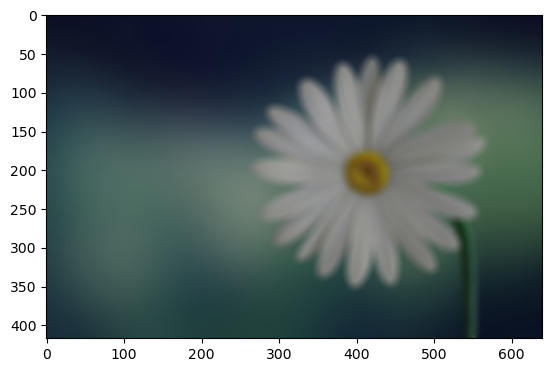

In [17]:
output_image = process_image(image_array)

# Display the image
plt.imshow(output_image)
output_image